In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import random
from itertools import permutations, combinations, combinations_with_replacement
from rich.progress import track
from rich.progress import Progress
from joblib import Parallel, delayed


In [2]:


def gen_momentum_vectors(N):
    #generate random 2d, unit vectors ---> (x, z)
    x_vals = np.random.uniform(-1, 1, size = N)
    z_vals = np.random.uniform(-1, 1, size = N)
    
    J_plus = np.asarray([np.asarray([x, z]).reshape(2,1) for x, z in zip(x_vals, z_vals)])
    J_minus = np.asarray([-1*Jp for Jp in J_plus])
    
    return [J_plus, J_minus]


vecs = gen_momentum_vectors(10)



In [3]:
def gen_measurement_vector(theta):
    #generate a measurement vector --> (x,z)
    #functions assume radians
    components = np.array(([np.sin(theta),np.cos(theta)]))
    magnitude = math.sqrt(sum(pow(element, 2) for element in components))
    unit_vector = components/magnitude
    return unit_vector



gen_measurement_vector(np.pi/4)

array([0.70710678, 0.70710678])

In [4]:

def check_thetas(thetas, val):
    mask = [theta == val for theta in thetas]
    return any(mask)



def experiment(number_of_momentum_vectors, theta_11 = None, theta_12 = None, theta_21 = None, theta_22 = None):
    thetas = [theta_11, theta_12, theta_21, theta_22]
    
    if check_thetas(thetas, None):
        raise ValueError(f"Thetas cannone be None. Thetas: {thetas}")

    #creates 4 experiement vectors from input theta
    alpha_1 = gen_measurement_vector(theta_11)
    alpha_2 = gen_measurement_vector(theta_12)
    beta_1 = gen_measurement_vector(theta_21)
    beta_2 = gen_measurement_vector(theta_22)
    
    #used to calcuate correlators 
    alpha_1_beta_1 = [] 
    alpha_2_beta_1 = [] 
    alpha_1_beta_2 = [] 
    alpha_2_beta_2 = []
    
    #creates N momentum vectors
    momentum_vectors = gen_momentum_vectors(number_of_momentum_vectors)
   
    #does experiment
    for up_momentum_vectors in momentum_vectors[0]:
        #randomly chooses an alpha and a beta
        #print(np.random.uniform(0, 1, size = 1)[0])
        counter_alpha = 0 
        counter_beta = 0
        if random.randint(1, 2)  == 1:
            measurement_1 = alpha_1
            counter_alpha += 1
        else: 
            measurement_1 = alpha_2
            counter_alpha += 2
            
        if random.randint(1, 2) == 1:
            measurement_2 = beta_1
            counter_beta += 1
        else: 
            measurement_2 = beta_2
            counter_beta += 2
        #normalize momentum vectors
        components = np.array(up_momentum_vectors)
        magnitude = math.sqrt(sum(pow(element, 2) for element in components))
        unit_vector = components/magnitude
        
       
        
        #measurements
        a_alpha_i = np.sign(np.dot(measurement_1,unit_vector))
        b_beta_i = -np.sign(np.dot(measurement_2,unit_vector))
        
        #print(a_alpha_i,b_beta_i)
        measurement = int(a_alpha_i[0])*int(b_beta_i[0])
        
        
        #sorts measruements into 4 correlators to later calculate CHSH correlator
        
        #problem here alpha_2_beta_1 array not populating
        if counter_alpha == 1 and counter_beta == 1:
            alpha_1_beta_1.append(measurement)
        elif counter_alpha == 1 and counter_beta == 2: 
            alpha_1_beta_2.append(measurement)
        elif counter_alpha == 2 and counter_beta == 1:
            alpha_2_beta_1.append(measurement)
        elif counter_alpha == 2 and counter_beta == 2:
            alpha_2_beta_2.append(measurement)
        
    #print(alpha_1_beta_1,alpha_1_beta_2,alpha_2_beta_1,alpha_2_beta_2)
        
    
    correlator_11 = np.sum(alpha_1_beta_1)/len(alpha_1_beta_1)
    correlator_12 = np.sum(alpha_1_beta_2)/len(alpha_1_beta_2)
    correlator_21 = np.sum(alpha_2_beta_1)/len(alpha_2_beta_1) 
    correlator_22 = np.sum(alpha_2_beta_2)/len(alpha_2_beta_2)
    
    #print(correlator_11,correlator_12,correlator_21,correlator_22)
    S_classic = correlator_11 + correlator_12 + correlator_21 - correlator_22    
    
    S_quantum = -np.cos(theta_11-theta_21)-np.cos(theta_11-theta_22)-np.cos(theta_12-theta_21)+np.cos(theta_12-theta_22)
        
    
    return [S_classic, S_quantum]

y_axis_classical = []
y_axis_quantum = []
x_axis = []
number_of_experiments = 10000 #has to be big,N->infinity
angle_divisions = 100

for angle in np.linspace(0,2*np.pi,angle_divisions):
    
    angles = {
    "theta_11" : 0*angle,
    "theta_12" : .75*angle,
    "theta_21" :  0 * angle,
    "theta_22" : 3*angle
    }
    
    #print(angles)
    
    
    classic, quantum = experiment(number_of_experiments, **angles)
    #print(classic,quantum)
    #print("Correlator: ", experiment(angle,2000), "Angle(in radians): ", angle)
    x_axis.append(angle)
    y_axis_classical.append(classic)
    y_axis_quantum.append(quantum)
    #print(experiment(angle,number_of_experiments), angle)
        


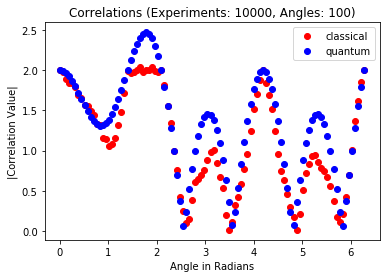

In [5]:
plt.xlabel('Angle in Radians')
plt.ylabel('|Correlation Value|')
plt.title(f'Correlations (Experiments: {number_of_experiments}, Angles: {angle_divisions})')
plt.plot(x_axis,np.abs(y_axis_classical),'ro')
plt.plot(x_axis,np.abs(y_axis_quantum),'bo')
plt.legend(["classical", "quantum"])



In [6]:
print(max(abs(np.asarray(y_axis_classical))))


2.034090449159659


In [7]:


def get_theta_ratios(max_ratio, divisions):
    """Generates a list of theta ratios between 0 and max_ratio devided evenly by divisions

    Args:
        max_ratio (int): maximum integer rati0
        divisions (int): number of spaced divisions between 0 and max_ratio

    Returns:
        list: list of angle ratios, ie) [0, 0.25, 0.5, 1].  will eventually correspond to the arguments: [0*angle, 0.25*angle, 0.5*angle, 1*angle] later in the code
    """

    vals = [max_ratio*i*(1/divisions) for i in range(divisions + 1)]
    vals = vals + [i for i in range(1, max_ratio)]

    return sorted(list(set(vals)))


def gen_theta_ratio_permutations(thetas_ratios):
    """Generates all posible permutations of the angles above using the combinations len(thetas ratios) choose 4, since we need 4 angles for each experiment

    Args:
        thetas_ratios (list): return value of get_theta_ratios

    Returns:
        list of lists: list of each permutation of thetas_ratios
    """

    comb_vals = list(combinations_with_replacement(thetas_ratios, r=4))
    all_perms = []
    for i in range(len(comb_vals)):
        comb = list(comb_vals[i])
        perms = list(set(permutations(comb)))
        all_perms += perms

    return list(set(all_perms))


def gen_angles_list(angle_divisions, theta_ratios):

    angles_list = []

    for angle in np.linspace(0, 2*np.pi, angle_divisions):

        angles = {
            "theta_11": theta_ratios["theta_11"]*angle,
            "theta_12": theta_ratios["theta_12"]*angle,
            "theta_21": theta_ratios["theta_21"]*angle,
            "theta_22": theta_ratios["theta_22"]*angle
        }
        
        angles_list.append(angles)
        
    return angles_list


def gen_experiment_set_parallel(theta_ratios, angle_divisions=100, number_of_experiments=100, progress=None, task=None):

    y_axis_classical = []
    y_axis_quantum = []
    x_axis = []

    ret = {}
    ret.update(theta_ratios)

    exp_num = 1

    #print(f"Completed experiment{exp_num}")

    exp_num += 1

    skip_update = progress == None and task == None

    if not skip_update:
        progress.update(task, advance=1)

    angles_list = gen_angles_list(angle_divisions, theta_ratios)
    #c = Parallel(n_jobs=5)(delayed(sqrt)(i ** 2) for i in range(100000))
    results = Parallel(n_jobs=4)(delayed(experiment)(number_of_experiments, **angles) for angles in angles_list)
    
    classical_results = np.asarray([results[i][0] for i in range(len(results))])
    quantum_results = np.asarray([results[i][1]for i in range(len(results))])
    
    res_dict = {
        "classical_max_value": np.max(classical_results),
        "quantum_max_value": np.max(quantum_results)
    }
    
    ret.update(res_dict)
    
    return ret


def gen_experiment_set(theta_ratios, angle_divisions=100, number_of_experiments=100, progress=None, task=None):
    y_axis_classical = []
    y_axis_quantum = []
    x_axis = []

    ret = {}
    ret.update(theta_ratios)

    exp_num = 1

    #print(f"Completed experiment{exp_num}")

    exp_num += 1

    skip_update = progress == None and task == None

    if not skip_update:
        progress.update(task, advance=1)

    for angle in np.linspace(0, 2*np.pi, angle_divisions):

        angles = {
            "theta_11": theta_ratios["theta_11"]*angle,
            "theta_12": theta_ratios["theta_12"]*angle,
            "theta_21": theta_ratios["theta_21"]*angle,
            "theta_22": theta_ratios["theta_22"]*angle
        }

        # print(angles)

        classic, quantum = experiment(number_of_experiments, **angles)
        # print(classic,quantum)
        # print("Correlator: ", experiment(angle,2000), "Angle(in radians): ", angle)

        # x_axis.append(angle)
        # y_axis_classical.append(classic)
        # y_axis_quantum.append(quantum)

        x_axis = np.append(x_axis, [angle])
        y_axis_classical = np.append(y_axis_classical, [abs(classic)])
        y_axis_quantum = np.append(y_axis_quantum, [abs(quantum)])
        # print(experiment(angle,number_of_experiments), angle)

        quantum_max_index = np.where(
            y_axis_quantum == np.max(y_axis_quantum))[0][0]
        classical_max_index = np.where(
            y_axis_classical == np.max(y_axis_classical))[0][0]

    results = {
        "classical_max_angle": np.rad2deg(y_axis_classical[classical_max_index]),
        "quantum_max_angle": np.rad2deg(y_axis_quantum[quantum_max_index]),
        "classical_max_value": y_axis_classical[classical_max_index],
        "quantum_max_value": y_axis_quantum[quantum_max_index]
    }

    ret.update(results)

    return ret


def build_params(all_perms, angle_divisions, number_of_experiments, progress, task):
    # builds parameter dictionary for gen_experiment_set
    params = []
    for perm in all_perms:
        perm_dict = {
            "theta_11": perm[0],
            "theta_12": perm[1],
            "theta_21": perm[2],
            "theta_22": perm[3]
        }

        d = {
            'theta_ratios': perm_dict,
            'angle_divisions': angle_divisions,
            'number_of_experiments': number_of_experiments,
            'progress': progress,
            'task': task
        }

        params.append(d)

    return params


def gen_all_experiment_sets_parallel(max_ratio, divisions, angle_divisions=100, number_of_experiments=100, downsample=None):

    thetas_ratios = get_theta_ratios(max_ratio, divisions)
    all_perms = gen_theta_ratio_permutations(thetas_ratios)

    if downsample:
        all_perms = all_perms[:downsample]

    all_exp_sets = []

    # with Progress() as progress:

    #task1 = progress.add_task("[green]Processing...", total=len(all_perms))

    # returns a list of param dictionaries
    params = build_params(all_perms, angle_divisions,
                          number_of_experiments, progress=None, task=None)

    all_exp_sets = Parallel(n_jobs=5)(
        delayed(gen_experiment_set)(params[i]) for i in range(len(params)))

    print("Done")
    return pd.DataFrame(all_exp_sets, index=list(range(len(all_exp_sets))))


def gen_all_experiment_sets(max_ratio, divisions, angle_divisions=100, number_of_experiments=100, downsample=None):

    thetas_ratios = get_theta_ratios(max_ratio, divisions)
    all_perms = gen_theta_ratio_permutations(thetas_ratios)

    if downsample:
        all_perms = all_perms[:downsample]

    all_exp_sets = []

    # True if downsample is given as an argument, else False

    with Progress() as progress:

        task1 = progress.add_task("[green]Processing...", total=len(all_perms))

        for i in range(len(all_perms)):
            progress.update(task1, advance=1)
            perm = all_perms[i]

            # creating dict of theta ratios
            perm_dict = {
                "theta_11": all_perms[i][0],
                "theta_12": all_perms[i][1],
                "theta_21": all_perms[i][2],
                "theta_22": all_perms[i][3]
            }

            a_set = gen_experiment_set_parallel(
                theta_ratios=perm_dict, angle_divisions=angle_divisions, number_of_experiments=number_of_experiments)

            all_exp_sets.append(a_set)

    print("Done.")
    return pd.DataFrame(all_exp_sets, index=list(range(len(all_exp_sets))))


perms = gen_all_experiment_sets(3, 4, downsample=None, number_of_experiments=10000, angle_divisions=10)


perms.to_csv("Beeg_Output.csv")


"""

theta_ratios = {
    "theta_11": 0,
    "theta_12": 1,
    "theta_21": 3,
    "theta_22": 1
}

gen_experiment_set_parallel(theta_ratios, angle_divisions=10, number_of_experiments=4000, progress=None, task=None)

"""


C:\Users\jacob\AppData\Local\Programs\Python\Python37-32\lib\site-packages\rich\live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
df = pd.read_csv("Beeg_Output.csv")
df.head(5)


,Unnamed: 0,theta_11,theta_12,theta_21,theta_22,classical_max_value,quantum_max_value
0,0,0.00,0.75,0.00,3.0,0.569677,1.000000
1,1,2.25,3.00,2.25,3.0,2.000000,2.000000
2,2,1.00,0.00,0.75,3.0,1.995676,2.000000
3,3,2.00,0.75,2.00,3.0,1.407492,1.879385
4,4,3.00,3.00,3.00,0.0,-1.975435,-2.000000


In [ ]:
#df.plot.scatter("classical_max_angle", "classical_max_value")

df[df['quantum_max_value'] == df['quantum_max_value'].max()]

,Unnamed: 0,theta_11,theta_12,theta_21,theta_22,classical_max_value,quantum_max_value
2015,2015,0.0,0.75,2.0,1.0,1.956495,2.732051


In [ ]:

#df[df['classical_max_value'] == df['classical_max_value'].max()]
df[df['classical_max_value'] > 2]

,Unnamed: 0,theta_11,theta_12,theta_21,theta_22,classical_max_value,quantum_max_value
6,6,0.00,0.75,1.50,3.00,2.011362,2.500000
12,12,1.50,2.25,0.75,0.00,2.015216,2.500000
15,15,1.00,0.75,2.00,2.25,2.022396,2.319078
22,22,1.50,3.00,1.00,3.00,2.002887,2.266044
29,29,0.75,3.00,2.00,2.25,2.017584,2.366025
...,...,...,...,...,...,...,...
2368,2368,3.00,2.00,0.75,0.75,2.031369,2.000000
2372,2372,1.00,0.75,2.25,3.00,2.017794,2.366025
2380,2380,1.50,0.00,2.00,3.00,2.013617,2.000000
2386,2386,2.25,0.75,1.50,3.00,2.021239,2.598076


In [ ]:
df[df["quantum_max_value"].duplicated()]

,theta_11,theta_12,theta_21,theta_22,classical_max_angle,quantum_max_angle,classical_max_value,quantum_max_value
5,3.00,3.00,3.0,0.75,151.109748,114.591559,2.637363,2.000000
7,2.25,1.50,0.0,2.00,122.176429,114.591559,2.132381,2.000000
9,2.25,0.75,3.0,3.00,120.950761,114.591559,2.110989,2.000000
10,1.00,0.75,1.0,1.00,146.544975,114.591559,2.557692,2.000000
11,1.00,0.75,1.0,1.50,171.620225,114.591559,2.995338,2.000000
...,...,...,...,...,...,...,...,...
2396,0.75,1.00,3.0,0.75,152.656116,129.211742,2.664352,2.255170
2397,2.00,0.00,1.0,2.00,157.117760,143.239449,2.742222,2.500000
2398,0.00,0.00,0.0,3.00,167.794783,114.591559,2.928571,2.000000
2399,2.00,0.00,1.0,2.25,166.263678,161.192413,2.901849,2.813338


array([[<AxesSubplot: title={'center': 'classical_max_value'}>]],
      dtype=object)

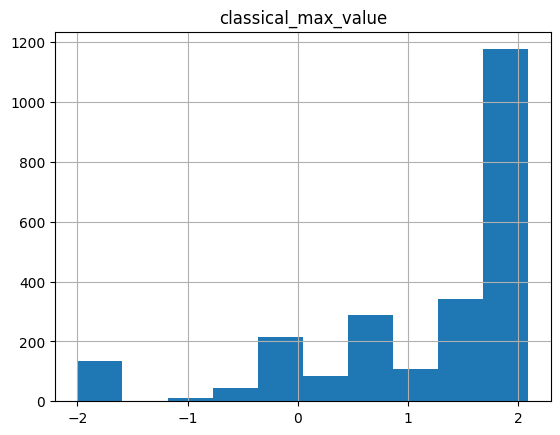

In [ ]:
df.hist('classical_max_value')


array([[<AxesSubplot: title={'center': 'quantum_max_value'}>]],
      dtype=object)

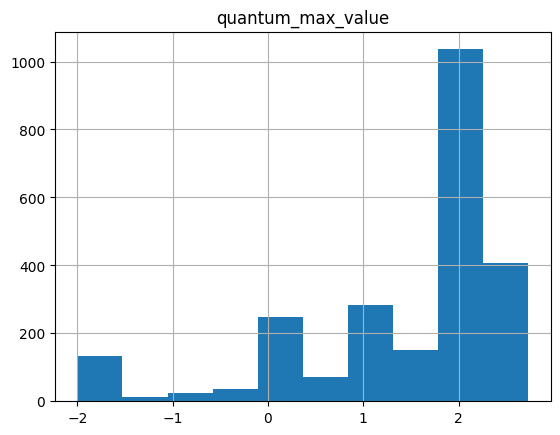

In [ ]:
df.hist("quantum_max_value")